<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>


# Modeling Trade Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import datetime
import pytz
import os
import glob
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa import stattools
from scipy.signal import savgol_filter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
tz = pytz.timezone('America/New_York')

def millions(x, pos):
    return '%1.1fM' % (x*1e-6)

set()

formatter = FuncFormatter(millions)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context('notebook', font_scale=1.5,rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette("Paired"))

## Notes

### Datasets

The notebook assumes the data is downloaded to the same datasets location. Please adjust the data loaders (pd.read_xxx) to fit your environemnt. set the os.chdir to point to your root directory of the git_hub repo.
A few simple datasets are in the datasets directory of the git_hub repo. Others you need to download from a Google Drive using this link: https://drive.google.com/open?id=1h97WHmearGEOW34g0NvhOtW6BdFC7ZAx. 

### Charts
Note that the charts from the book are generated directly from these notebooks. So you'll find places where charts might be duplicated with subtle change just so that we can create the charts appropriate for the book. Also note that most of the charts in the book don't have titles since we already have the latex title in the figure. This is why the set_title code is after the plot saving code.

In [ ]:
#Please change to the location of the git_hub reporsitory
os.chdir('/Users/nehrend/work/algo_trading_book/')

One of the often ignored steps for creating stable profile is to remove any dates that are known to have very different behavior. We called these special days and you can get a calendar for reference at: https://www.nasdaq.net/PublicPages/assets/MyMID/2016_Trade_Calendar.pdf

One should do some more thorough analysis to see what other special days should be used. For example the Eranings days for a particular stock should be removed as well. We leave this to the reader if interested. The approach is exactly the same.

In [156]:
fomc_dates = ['2016-01-27','2016-03-16','2016-04-27','2016-06-15','2016-07-21','2016-11-2','2016-12-14']
half_days =['2016-11-25']
russell_rebal=['2016-06-24']
msci_rebal = ['2016-02-29','2016-05-31','2016-08-31','2016-11-30']
quad_witching = ['2016-03-18','2016-06-17','2016-09-16','2016-12-16']
month_end =  ['2016-01-15', '2016-02-19', '2016-04-15', '2016-05-20', '2016-07-15', '2016-08-19', '2016-10-22', '2016-11-18']

special_days = np.sort(list(set(fomc_dates + half_days + russell_rebal + msci_rebal + quad_witching + month_end )))
all_days = min_bars.index.unique(level='Date').astype('str').values
regular_days = list(set(all_days) - set(special_days))

## Order Size Normalization

In [181]:
amzn_d = pd.read_csv('datasets/AMZN.csv',parse_dates=True,index_col='Date').sort_index()
amzn_16r = amzn_d.loc[pd.DatetimeIndex(regular_days),:].sort_index()

amzn_d.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2017-12-22,1172.08,1174.62,1167.83,1168.36,1553997.0,0.0,1.0,1172.08,1174.62,1167.83,1168.36,1553997.0
2017-12-26,1168.36,1178.32,1160.55,1176.76,1964871.0,0.0,1.0,1168.36,1178.32,1160.55,1176.76,1964871.0
2017-12-27,1179.91,1187.29,1175.61,1182.26,1779382.0,0.0,1.0,1179.91,1187.29,1175.61,1182.26,1779382.0
2017-12-28,1189.00,1190.10,1184.38,1186.10,1803460.0,0.0,1.0,1189.00,1190.10,1184.38,1186.10,1803460.0
2017-12-29,1182.35,1184.00,1167.50,1169.47,2625283.0,0.0,1.0,1182.35,1184.00,1167.50,1169.47,2625283.0


The daily volume is a very complex process with multiple seasonal components and regular shocks some of which are predicable (Earning announcements, Option Expiration, etc.) and some are "random". Let's look a the volume of a sample stock, AMZN (Amazon Inc.) from 2010 to date and also a zoomed in version for 2016.

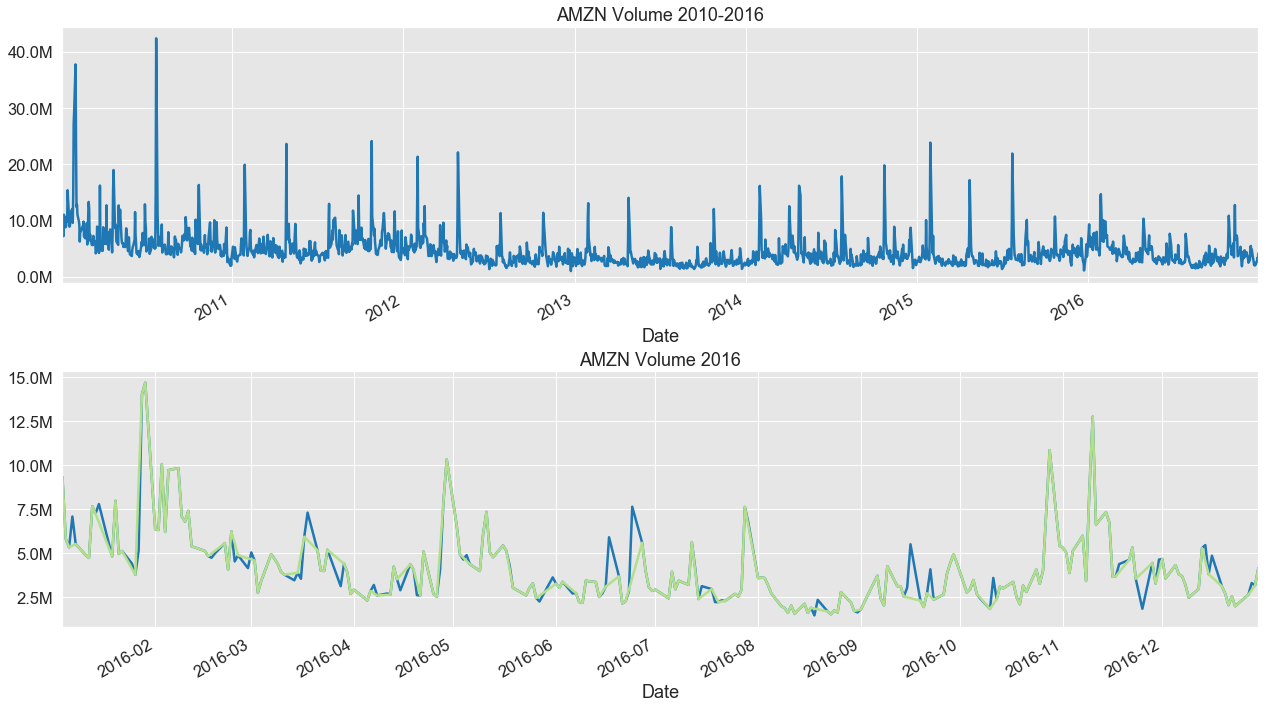

In [183]:
fig, ax = plt.subplots(2,1,figsize=(18,10),sharex=False)
_ = amzn_d.Volume['2010-01':'2016-12'].plot(ax=ax[0],color='C1')

_ = ax[0].yaxis.set_major_formatter(formatter)
_ = amzn_d.Volume['2016-01':'2016-12'].plot(ax=ax[1],color='C1')
_ = amzn_16r.Volume.plot(ax=ax[1],color='C2')
_ = ax[1].yaxis.set_major_formatter(formatter)
_ = ax[1].legend = ['all_day','regular_days']
plt.tight_layout()
plt.savefig('./book/chapters/chapter_trade_data_models/figures/daily_volume.png', format='png', dpi=300)
_ = ax[0].set_title('AMZN Volume 2010-2016')
_ = ax[1].set_title('AMZN Volume 2016')
plt.show()

Often in execution we look at order size normalized by some form of rolling average. A common rolling window is 64 days as it includes a rolling quarter and alway incorporates one quarterly earnings day where volume is usually a lot higher. We look at the difference between Mean and Median. One, as we can see is smoother and more stable while the other one is more reactive but more noisy.

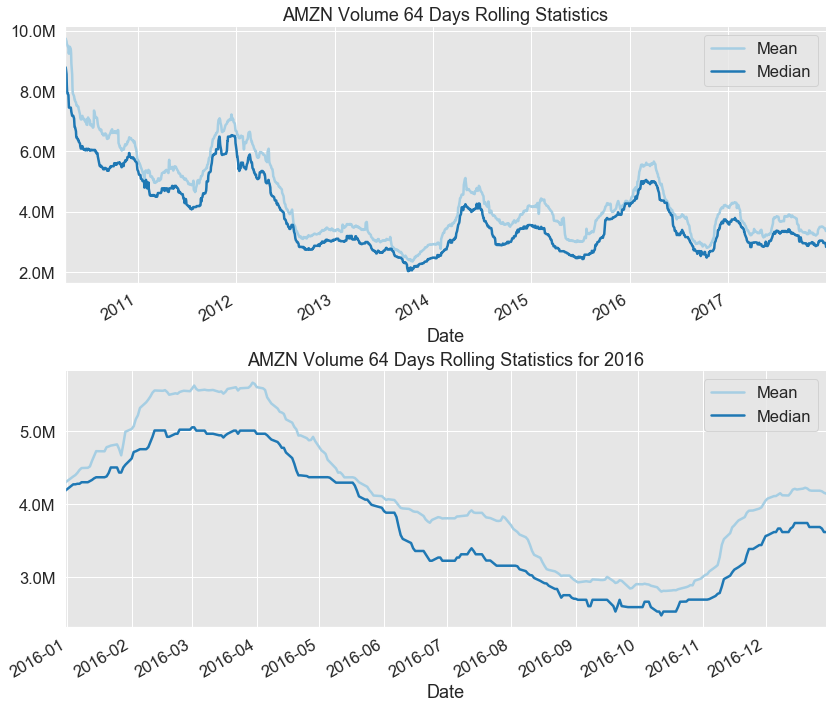

In [112]:
fig, ax = plt.subplots(2,1,figsize=(12,10),sharex=False)
_ = amzn_d.Volume.rolling(64).mean().dropna().plot(ax=ax[0])
_ = amzn_d.Volume.rolling(64).median().dropna().plot(ax=ax[0])
_ = ax[0].legend(labels=['Mean','Median'])
_ = ax[0].yaxis.set_major_formatter(formatter)
_ = amzn_d.Volume['2015-10':'2016-12'].rolling(64).mean().dropna().plot(ax=ax[1])
_ = amzn_d.Volume['2015-10':'2016-12'].rolling(64).median().dropna().plot(ax=ax[1])
_ = ax[1].legend(labels=['Mean','Median'])
_ = ax[1].yaxis.set_major_formatter(formatter)
sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_trade_data_models/figures/adv.png', format='png', dpi=300)
_ = ax[0].set_title("AMZN Volume 64 Days Rolling Statistics")
_ = ax[1].set_title("AMZN Volume 64 Days Rolling Statistics for 2016")
plt.show()

Let's take a closer look at 2016 and see what we can do as far as a simple TS modeling using the tools we learned in Chapter 2

First let's look at stationarity by running the ADF Augmented Test. The p-value is very small consitent with the stationarity hypothesis



In [12]:
adf_result = stattools.adfuller(amzn_d.Volume['2016-01':'2016-12'], autolag='AIC')
print('p-Value: {:.3e} is less than 0.001. Series is stationary'.format(adf_result[1]))

p-Value: 9.858e-02 is less than 0.001. Series is stationary


Next let's look at the ACF and PACF to get an idea of AR and MA component but also some possible seasonal components. We see that the series could possibly be modeled as an ARMA(1,2) but there is likely some seasonal component at the roughly monthly level.

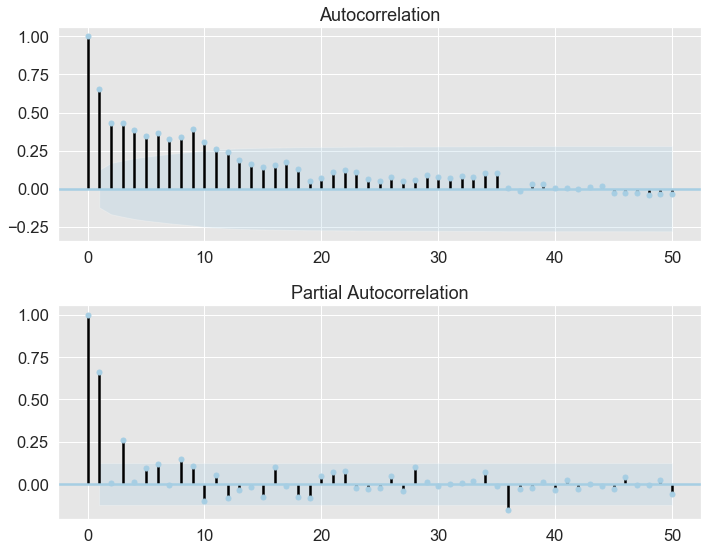

In [179]:
fig, ax = plt.subplots(2,figsize=(10,8))
_ = plot_acf(amzn_d.Volume['2016-01':'2016-12'], lags=50, ax=ax[0])
_ = plot_pacf(amzn_d.Volume['2016-01':'2016-12'], lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

Let's run a parameter scan to see which ARMA model is better suited. As it turns out ARMA(2,1) seems to do the best job.

In [14]:
# Optimize ARMA parameters
aicVal=[]
for ari in range(1, 3):
    for maj in range(1,3):
        arma_obj = stattools.ARMA(amzn_d.Volume['2016-01':'2016-11'].tolist(), order=(ari, maj)).fit(maxlag=30, method='mle', trend='nc')
        aicVal.append([ari, maj, arma_obj.aic])
pd.DataFrame(aicVal,columns=['AR(p)','MA(q)','AIC'])

,AR(p),MA(q),AIC
0,1,1,7282.482563
1,1,2,7249.052074
2,2,1,7259.182054
3,2,2,7251.044107


## Profiles

Let's load the minute bar pickle file that you have downloaded from the Google Drive and placed in the datasets directory. The dataset provides minute bar data for the most of the S&P 500 universe for 2016. This should give you a lot of data to play around with and analyze how some of these analytics behave.

In [3]:
min_bars = pd.read_pickle('./datasets/1_min_bars.gzip')
min_bars.head()

High    Low   Open   Close  Volume
Ticker Date       Bin                                     
A      2016-01-04 0    41.08  41.04  41.08  41.060     990
                  1    41.06  40.92  40.92  41.060      13
                  3    41.04  40.92  41.00  40.950   46046
                  4    41.00  40.94  41.00  40.990    9303
                  5    41.00  40.96  40.99  40.975   15475

In [4]:
min_bars.index.unique(level='Ticker').shape[0],min_bars.index.unique(level='Date').shape[0]

(482, 225)

Note: This dataset explicitly excludes the open and closing print. Those in general should be treated differently with a more sophisticated model. We'll briefly look at the open_close dataset later.

In [5]:
fomc_dates = ['2016-01-27','2016-03-16','2016-04-27','2016-06-15','2016-07-21','2016-11-2','2016-12-14']
half_days =['2016-11-25']
russell_rebal=['2016-06-24']
msci_rebal = ['2016-02-29','2016-05-31','2016-08-31','2016-11-30']
quad_witching = ['2016-03-18','2016-06-17','2016-09-16','2016-12-16']
month_end =  ['2016-01-15', '2016-02-19', '2016-04-15', '2016-05-20', '2016-07-15', '2016-08-19', '2016-10-22', '2016-11-18']

special_days = np.sort(list(set(fomc_dates + half_days + russell_rebal + msci_rebal + quad_witching )))
all_days = min_bars.index.unique(level='Date').astype('str').values
regular_days = list(set(all_days) - set(special_days))

Now that we have a list of the regular days we just removed them from the dataset

In [117]:
min_bars_r = min_bars.loc[pd.IndexSlice[:,regular_days,:],:]
min_bars_r.index.unique(level='Date').shape[0]

210

We look at a particular stock and create simple profiles for it. Please note that for solid production application a lot more care should be give but even this simple approach provide decent profiles that would not create significan problems for a production application. 

We start by normalizing the volume to work in percentage space. Very easily done with Pandas:

In [121]:
amzn_v = min_bars_r.loc['AMZN',['Volume']]
amzn_v = amzn_v.assign(Vol_pct = amzn_v.Volume.groupby('Date').transform(lambda x: x/x.sum()))
amzn_v.head()

Volume   Vol_pct
Date       Bin                  
2016-01-04 0    266818  0.029662
           1     70982  0.007891
           2     55901  0.006215
           3     43858  0.004876
           4     62055  0.006899

Next the raw_profile is generated by doing a simple bin-wise mean. After that we want to smoothe the profile. We use the Savitzky Golay filter that is usually a very robust approach to smoothing. https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

You will see that the beginning and the end, due to the boundary issues and the strong trend, the smoothing does not work very well. We apply a commn heuristic: We remove the first 3 and last 3 bins and smooth the center and the re-apply the unsmoothed bin. The new smoothing is much better. Look at the detail charts below

In [456]:
profile = amzn_v.loc[:,['Vol_pct']].groupby('Bin').mean()
profile = profile.assign(smoothed_profile = savgol_filter(profile.Vol_pct,31,3))
profile = profile.assign(smoothed_profile_2=np.concatenate((profile.Vol_pct[:3],savgol_filter(profile.Vol_pct[3:-3],31,3), profile.Vol_pct[-3:]),axis=0))

In [458]:
v_profile = (profile.assign(time = pd.timedelta_range('09:30:00','15:59:00',freq='1Min'))
           .rename(columns={'smoothed_profile_2':'profile'})
           .set_index('time'))[['profile']]
v_profile.to_csv('./datasets/amzn_profile.csv')

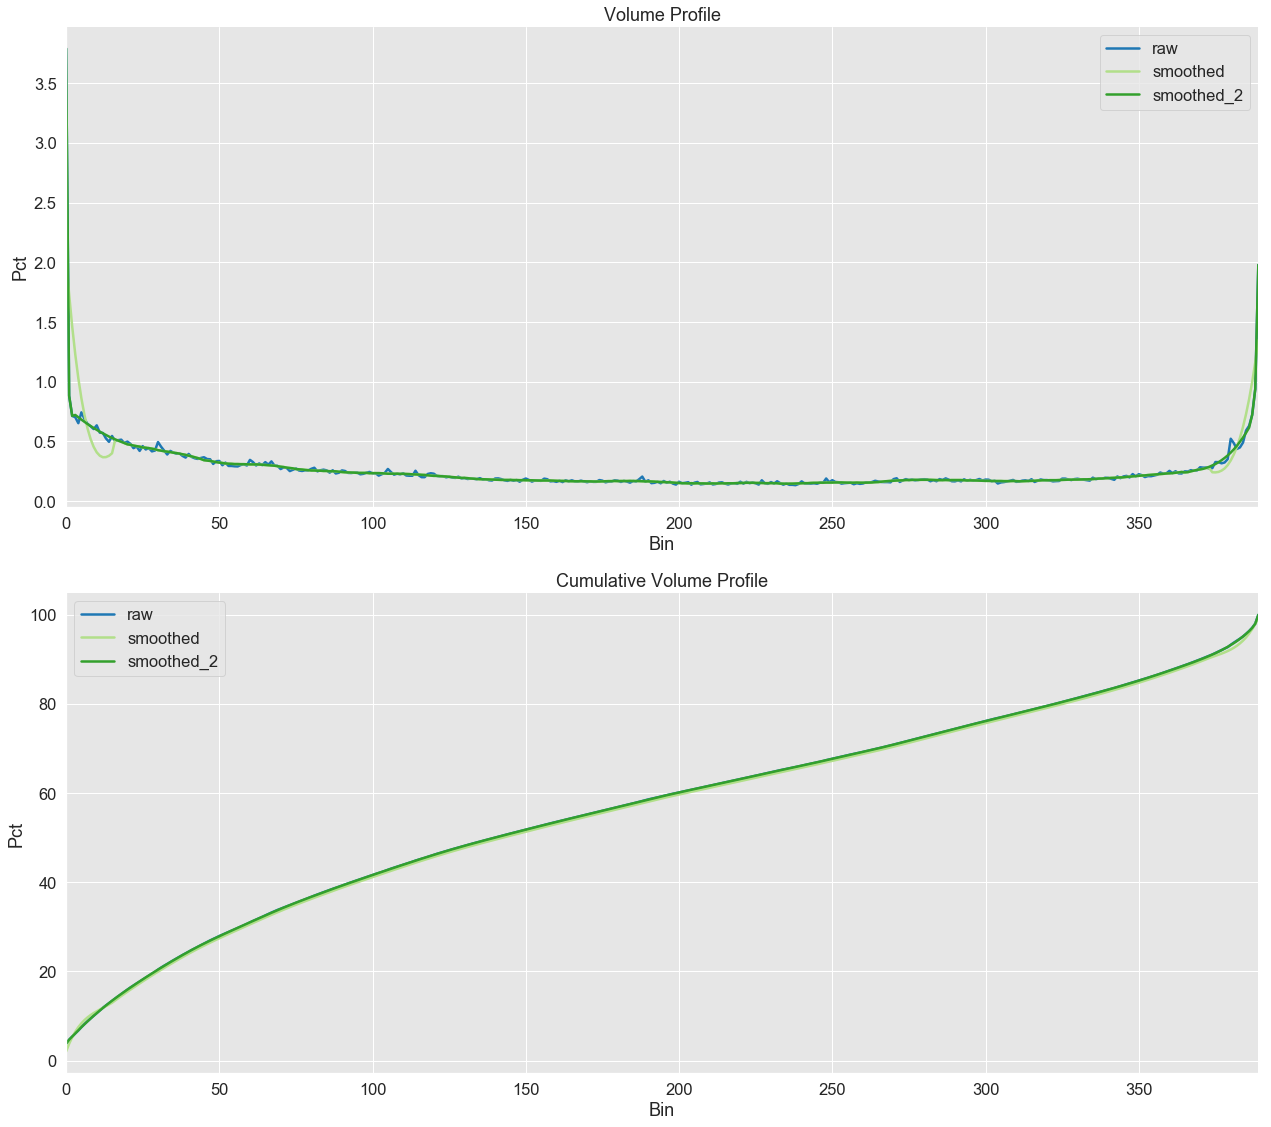

In [129]:
fig,ax = plt.subplots(2,1,figsize=(18,16))
_ = profile.multiply(100).round(3).plot(ax = ax[0],color=['C1','C2','C3'],)
ax[0].set_ylabel('Pct')
ax[0].legend(['raw','smoothed','smoothed_2'])
ax[0].set_title('Volume Profile')
_ = profile.cumsum().multiply(100).round(3).plot(ax =ax[1],color=['C1','C2','C3'],legend=['raw','smoothed'])
ax[1].set_ylabel('Pct')
ax[1].legend(['raw','smoothed','smoothed_2'])
ax[1].set_title('Cumulative Volume Profile')
sns.despine()
plt.tight_layout()
plt.show()

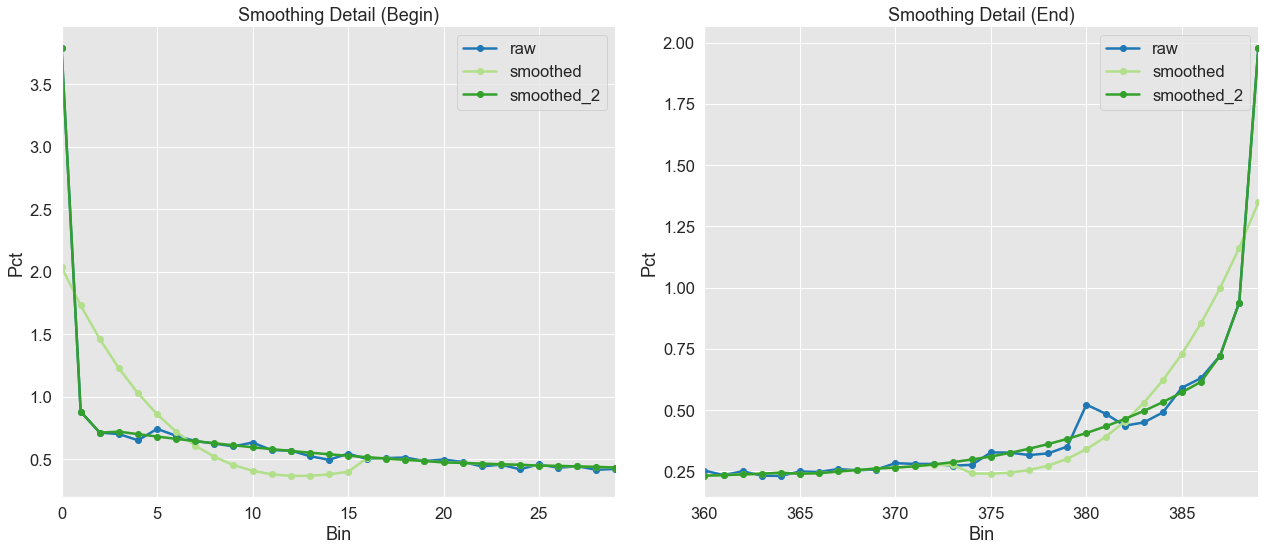

In [132]:
fig,ax = plt.subplots(1,2,figsize=(18,8),sharey=False)
_ = profile[:30].multiply(100).round(3).plot(ax = ax[0],color=['C1','C2','C3'],marker='o')
_ = ax[0].set_ylabel('Pct')
_ = ax[0].set_title('Smoothing Detail (Begin)')
_ = ax[0].legend(['raw','smoothed','smoothed_2'])
_ = profile[-30:].multiply(100).round(3).plot(ax = ax[1],color=['C1','C2','C3'],marker='o')
_ = ax[1].set_ylabel('Pct')
_ = ax[1].set_title('Smoothing Detail (End)')
_ = ax[1].legend(['raw','smoothed','smoothed_2'])
sns.despine()
plt.tight_layout()
plt.show()

Redo the plots in a cleaner way for the chart in the book

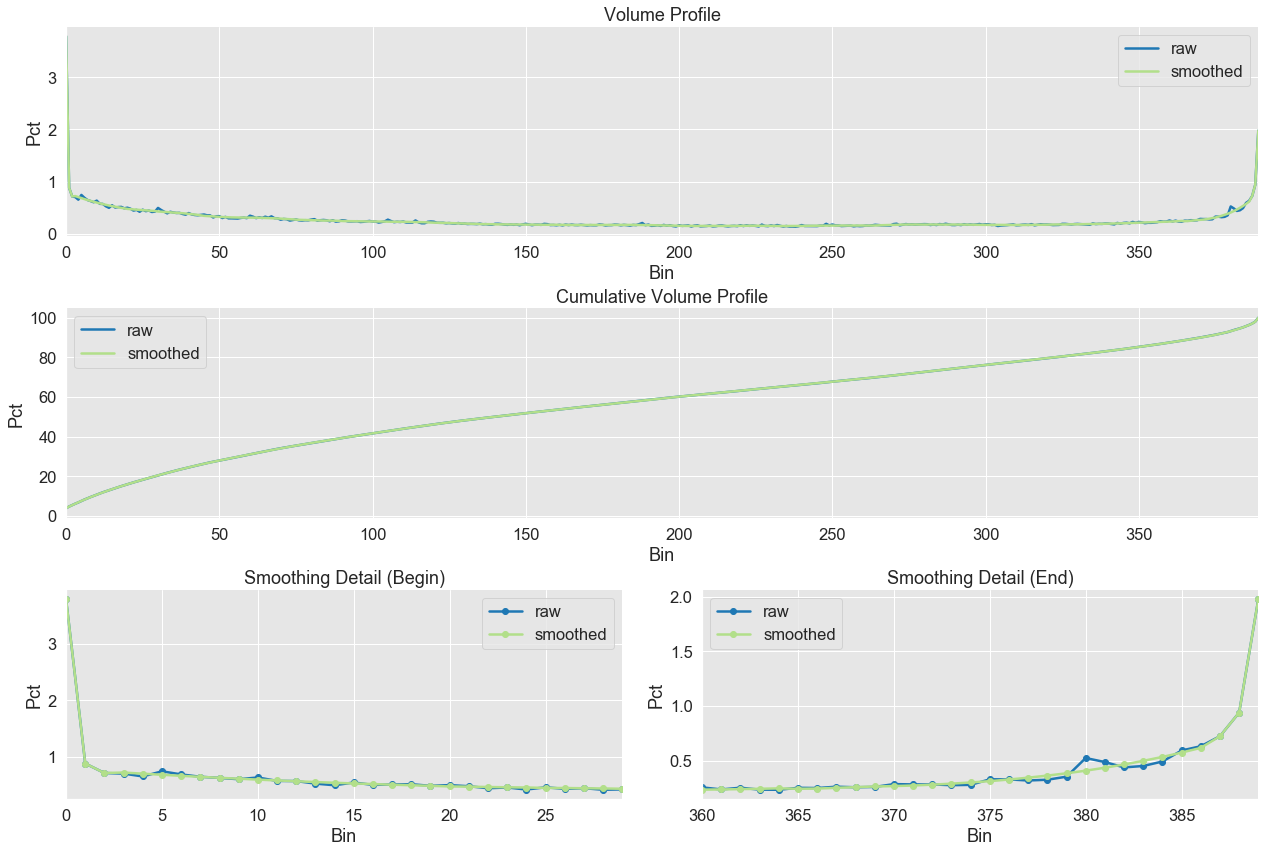

In [141]:
profile_g = profile.drop(columns='smoothed_profile')
fig = plt.figure(figsize = (18,12))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=1)
ax4 = plt.subplot2grid((3, 2), (2, 1), colspan=1)
_ = profile_g.multiply(100).round(3).plot(ax = ax1,color=['C1','C2'])
_ = ax1.set_ylabel('Pct')
_ = ax1.legend(['raw','smoothed'])

_ = profile_g.cumsum().multiply(100).round(3).plot(ax =ax2,color=['C1','C2'])
_ = ax2.set_ylabel('Pct')
_ = ax2.legend(['raw','smoothed'])

_ = profile_g[:30].multiply(100).round(3).plot(ax = ax3,color=['C1','C2'],marker='o')
_ = ax3.set_ylabel('Pct')

_ = ax3.legend(['raw','smoothed'])
_ = profile_g[-30:].multiply(100).round(3).plot(ax = ax4,color=['C1','C2'],marker='o')
_ = ax4.set_ylabel('Pct')

_ = ax4.legend(['raw','smoothed'])

sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_trade_data_models/figures/amzn_profile.png', format='png', dpi=300)
_ = ax1.set_title('Volume Profile')
_ = ax2.set_title('Cumulative Volume Profile')
_ = ax3.set_title('Smoothing Detail (Begin)')
_ = ax4.set_title('Smoothing Detail (End)')
plt.show()

### Special Days profiles

Let's look at a very charateristic special day: The FOMC announcement. At 2PM the Fed provide infromation around the Fereral Fund Rate which is a critical benchmark for the cost of lending. This infromation can have a significan impact on the market. For this reason a lot of volume slows down just before that and spikes right after the announcement.
We'll use this to discuss how these discontinuties can be handled.

We pool alld FOMC days for all stocks in order to provide enough samples to create a decently stable profile. You will see that this is more noisy than the previous one.
We apply the same smoothing technique and plot the profiles

In [142]:
fomc_bar = min_bars.loc[pd.IndexSlice[:,fomc_dates,:],['Volume']]
fomc_bar = fomc_bar.assign(Vol_pct = fomc_bar.Volume.groupby(['Ticker','Date']).transform(lambda x: x/x.sum()))
fomc_bar.head()

Volume   Vol_pct
Ticker Date       Bin                  
A      2016-01-27 0     13744  0.009994
                  1       106  0.000077
                  2      2466  0.001793
                  3      2243  0.001631
                  4      1193  0.000868

In [143]:
fomc_profile = fomc_bar.loc[:,['Vol_pct']].groupby('Bin').mean()
fomc_profile = fomc_profile.assign(smoothed_profile=np.concatenate((fomc_profile.Vol_pct[:3],savgol_filter(fomc_profile.Vol_pct[3:-3],61,3), fomc_profile.Vol_pct[-3:]),axis=0))

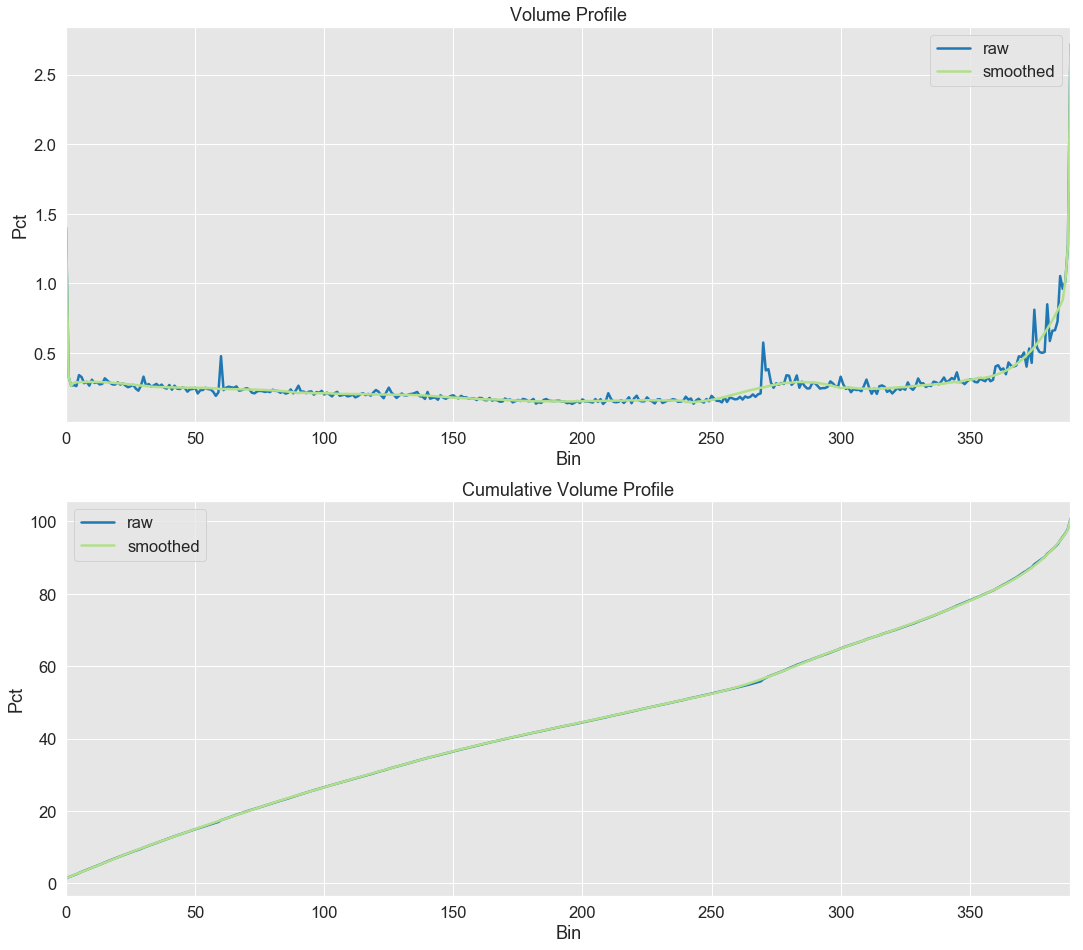

In [144]:
fig,ax = plt.subplots(2,1,figsize=(18,16))
_ = fomc_profile.multiply(100).round(3).plot(ax = ax[0],color=['C1','C2'],)
ax[0].set_ylabel('Pct')
ax[0].legend(['raw','smoothed'])
ax[0].set_title('Volume Profile')
_ = fomc_profile.cumsum().multiply(100).round(3).plot(ax =ax[1],color=['C1','C2'],legend=['raw','smoothed'])
ax[1].set_ylabel('Pct')
ax[1].legend(['raw','smoothed'])
ax[1].set_title('Cumulative Volume Profile')
plt.show()

Clearly visible at Bin 270 (i.e. 2PM) is the spike around the FOMC announcement. One also sees a spike at around 10:30 PM. This is actually quite tipical in many stocks although AMAZN did not disply a strong pattern there. If we look in detail at these period one see that the smoothing algorithm spread the spike which could force a strategy to overtrade ahead of the announcement and to undertrade right after

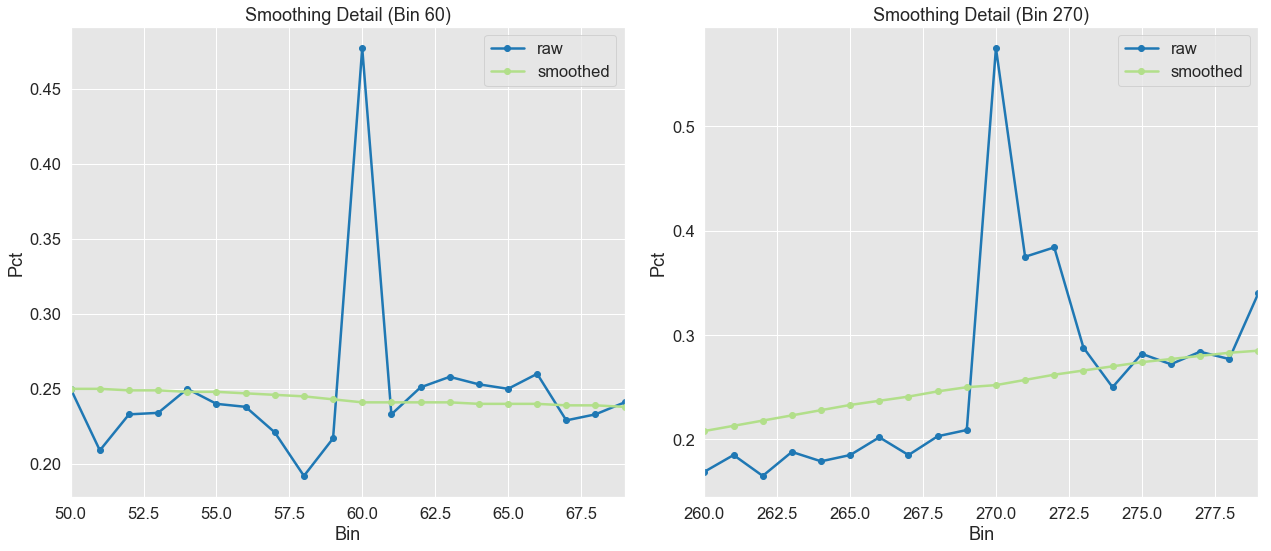

In [145]:
fig,ax = plt.subplots(1,2,figsize=(18,8),sharey=False)
_ = fomc_profile[50:70].multiply(100).round(3).plot(ax = ax[0],color=['C1','C2'],marker='o')
ax[0].set_ylabel('Pct')
ax[0].set_title('Smoothing Detail (Bin 60)')
ax[0].legend(['raw','smoothed'])
_ = fomc_profile[260:280].multiply(100).round(3).plot(ax = ax[1],color=['C1','C2'],marker='o')
ax[1].set_ylabel('Pct')
ax[1].set_title('Smoothing Detail (Bin 270)')
ax[1].legend(['raw','smoothed'])
plt.tight_layout()
plt.show()

One Common trick is to remove the jump from the profile and replace it with a value in between the previous and next steps. We then apply the smoothing and finally we re-apply the jump to the smoothed profile. Look at the improved approach to the smoothed profile

In [147]:
fomc_profile_adj = fomc_profile.Vol_pct.copy()

p_60 = fomc_profile_adj[60].copy()
p_fomc = fomc_profile_adj[270:273].copy()
fomc_profile_adj[60] = (fomc_profile_adj[59] + fomc_profile_adj[61])/2
fomc_profile_adj[270:273] = np.linspace(fomc_profile_adj[269],fomc_profile_adj[273],3)

fomc_profile = fomc_profile.assign(smoothed_profile_2=np.concatenate((fomc_profile_adj[:3],savgol_filter(fomc_profile_adj[3:-3],61,3), fomc_profile_adj[-3:]),axis=0))
fomc_profile.smoothed_profile_2[60]=p_60
fomc_profile.smoothed_profile_2[270:273]=p_fomc

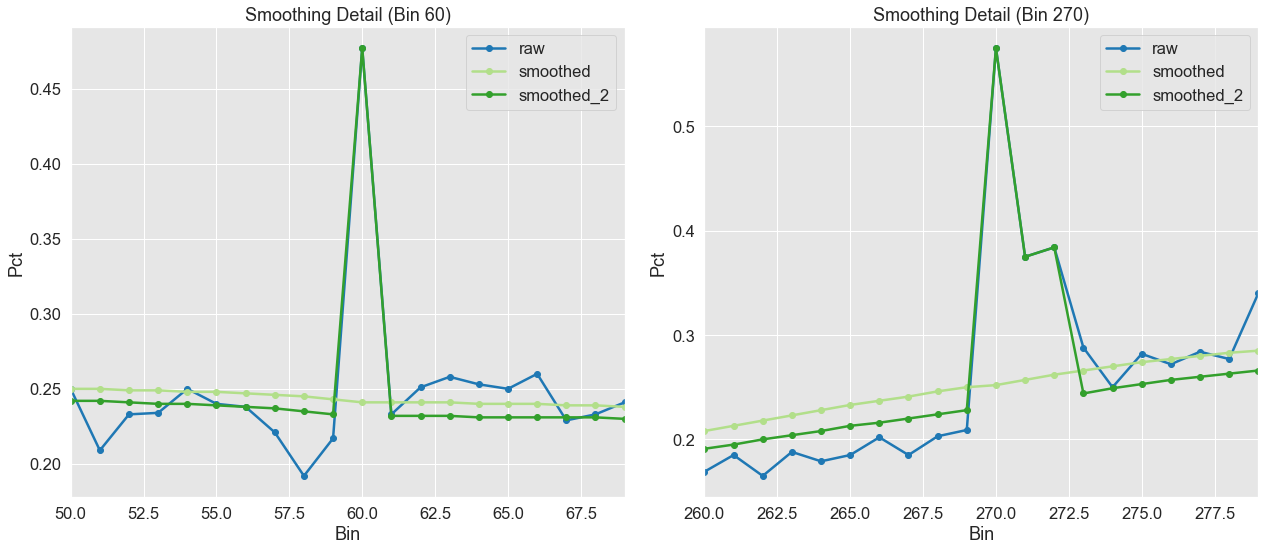

In [148]:
fig,ax = plt.subplots(1,2,figsize=(18,8),sharey=False)
_ = fomc_profile[50:70].multiply(100).round(3).plot(ax = ax[0],color=['C1','C2','C3'],marker='o')
ax[0].set_ylabel('Pct')
ax[0].set_title('Smoothing Detail (Bin 60)')
ax[0].legend(['raw','smoothed','smoothed_2'])
_ = fomc_profile[260:280].multiply(100).round(3).plot(ax = ax[1],color=['C1','C2','C3'],marker='o')
ax[1].set_ylabel('Pct')
ax[1].set_title('Smoothing Detail (Bin 270)')
ax[1].legend(['raw','smoothed','smoothed_2'])
plt.tight_layout()
plt.show()

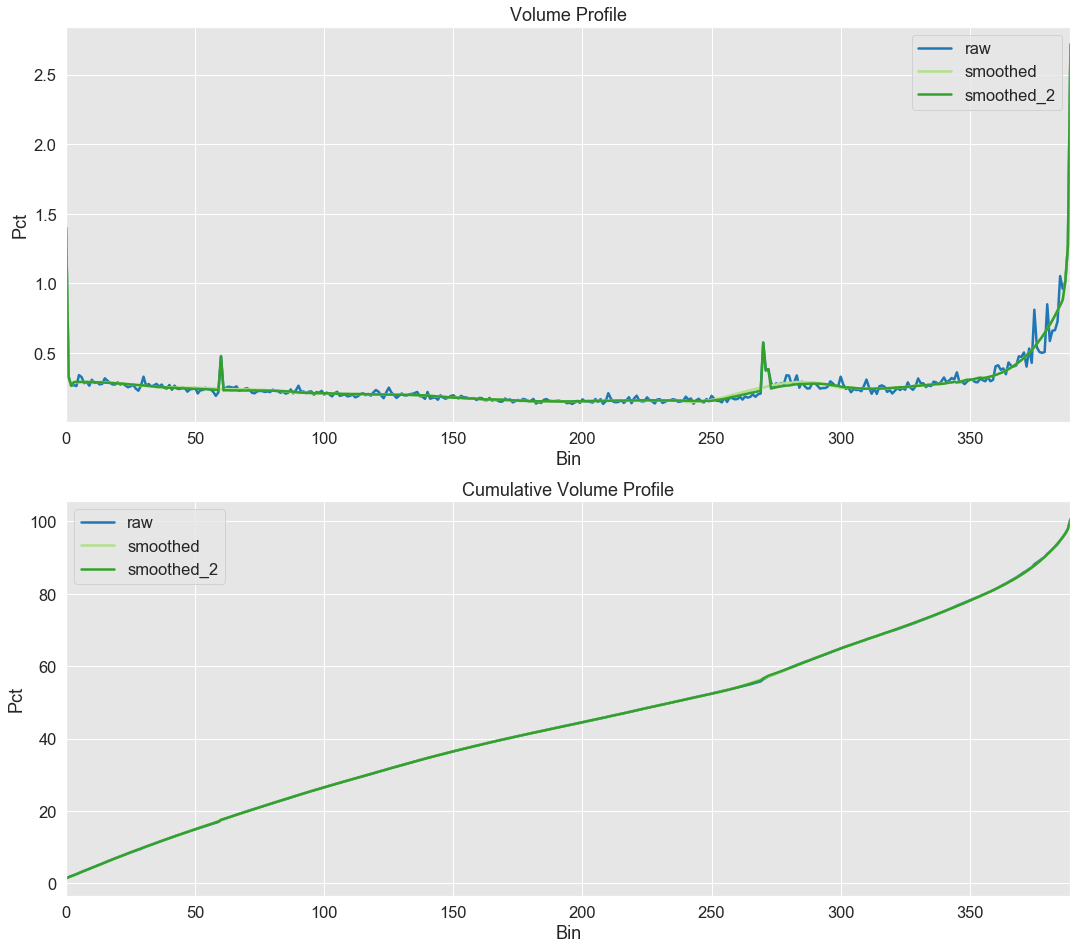

In [150]:
fig,ax = plt.subplots(2,1,figsize=(18,16))
_ = fomc_profile.multiply(100).round(3).plot(ax = ax[0],color=['C1','C2','C3'],)
ax[0].set_ylabel('Pct')
ax[0].legend(['raw','smoothed','smoothed_2'])
ax[0].set_title('Volume Profile')
_ = fomc_profile.cumsum().multiply(100).round(3).plot(ax =ax[1],color=['C1','C2','C3'],legend=['raw','smoothed'])
ax[1].set_ylabel('Pct')
ax[1].legend(['raw','smoothed','smoothed_2'])
ax[1].set_title('Cumulative Volume Profile')
plt.show()

Create the chart for the book

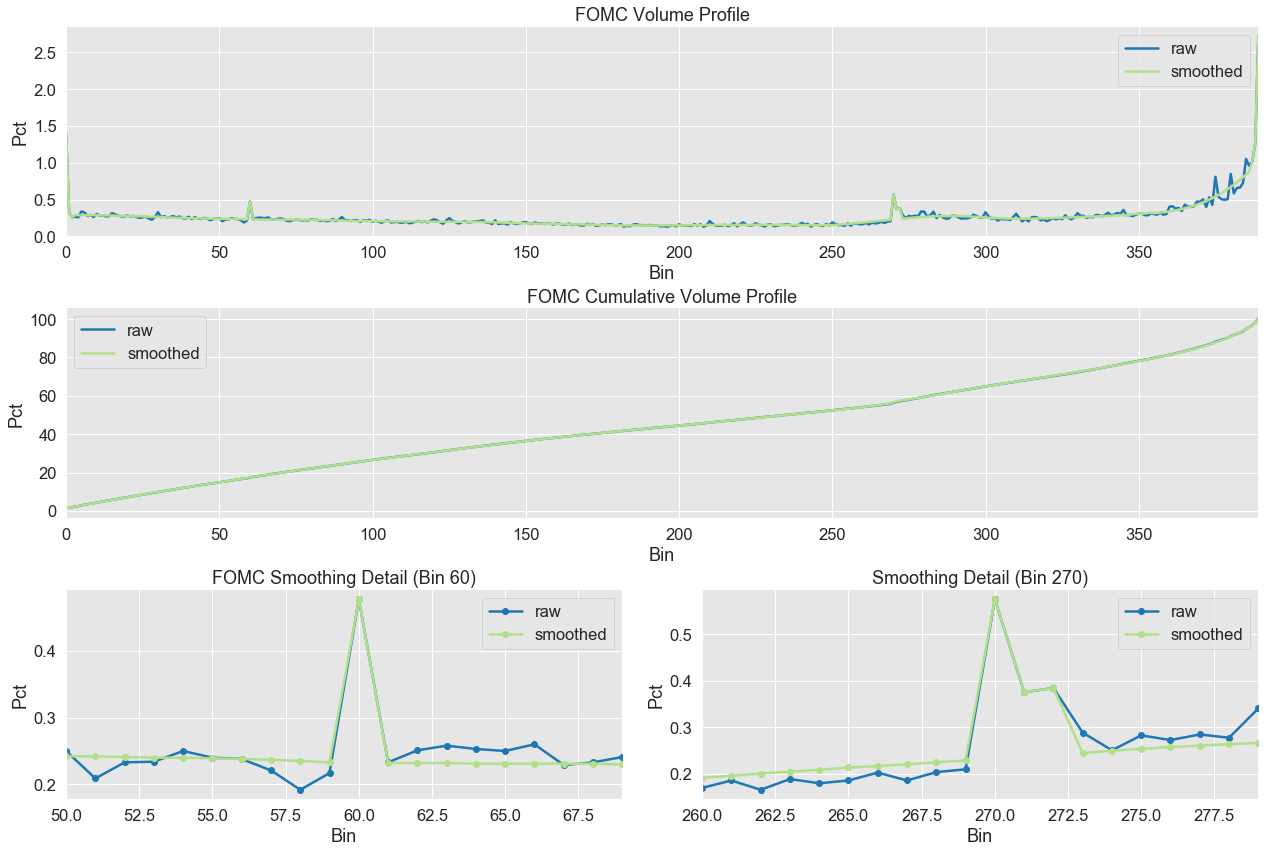

In [152]:
fomc_profile_g = fomc_profile.drop(columns='smoothed_profile')
fig = plt.figure(figsize = (18,12))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=1)
ax4 = plt.subplot2grid((3, 2), (2, 1), colspan=1)
_ = fomc_profile_g.multiply(100).round(3).plot(ax = ax1,color=['C1','C2'])
_ = ax1.set_ylabel('Pct')
_ = ax1.legend(['raw','smoothed'])

_ = fomc_profile_g.cumsum().multiply(100).round(3).plot(ax =ax2,color=['C1','C2'])
_ = ax2.set_ylabel('Pct')
_ = ax2.legend(['raw','smoothed'])

_ = fomc_profile_g[50:70].multiply(100).round(3).plot(ax = ax3,color=['C1','C2'],marker='o')
_ = ax3.set_ylabel('Pct')

_ = ax3.legend(['raw','smoothed'])
_ = fomc_profile_g[260:280].multiply(100).round(3).plot(ax = ax4,color=['C1','C2'],marker='o')
_ = ax4.set_ylabel('Pct')

_ = ax4.legend(['raw','smoothed'])

sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_trade_data_models/figures/fomc_profile.png', format='png', dpi=300)
_ = ax1.set_title('FOMC Volume Profile')
_ = ax2.set_title('FOMC Cumulative Volume Profile')
_ = ax3.set_title('FOMC Smoothing Detail (Bin 60)')
_ = ax4.set_title('Smoothing Detail (Bin 270)')
plt.show()

In [424]:
nbbo = pd.read_pickle('./datasets/nbbo_data.gzip').sort_index()
nbbo = nbbo.query("Ticker != 'BAC'")

In [425]:
nbbo = nbbo.assign(Mid_price = 0.5*(nbbo.Bid_price +nbbo.Ask_price))
nbbo.head(2)

Bid_ex  Bid_price Ask_ex  Ask_price  \
Ticker Timestamp                                                        
AMZN   2016-10-03 09:30:00.004580      P      835.0      Q     835.11   
       2016-10-03 09:30:00.013796      P      835.0      P     836.00   

                                   Bid_size  Ask_size  Mid_price  
Ticker Timestamp                                                  
AMZN   2016-10-03 09:30:00.004580       400       100    835.055  
       2016-10-03 09:30:00.013796       400       100    835.500

In [426]:
nbbo_m = nbbo.loc[:,['Mid_price']].drop_duplicates()

In [427]:
def char_time(df):
    d = {}
    d['char_time'] = df.Timestamp.diff().dropna().median().total_seconds()
    return pd.Series(data = d)

char_time = nbbo_m.reset_index().groupby(['Ticker',pd.Grouper(key='Timestamp', freq='D')]).apply(char_time)

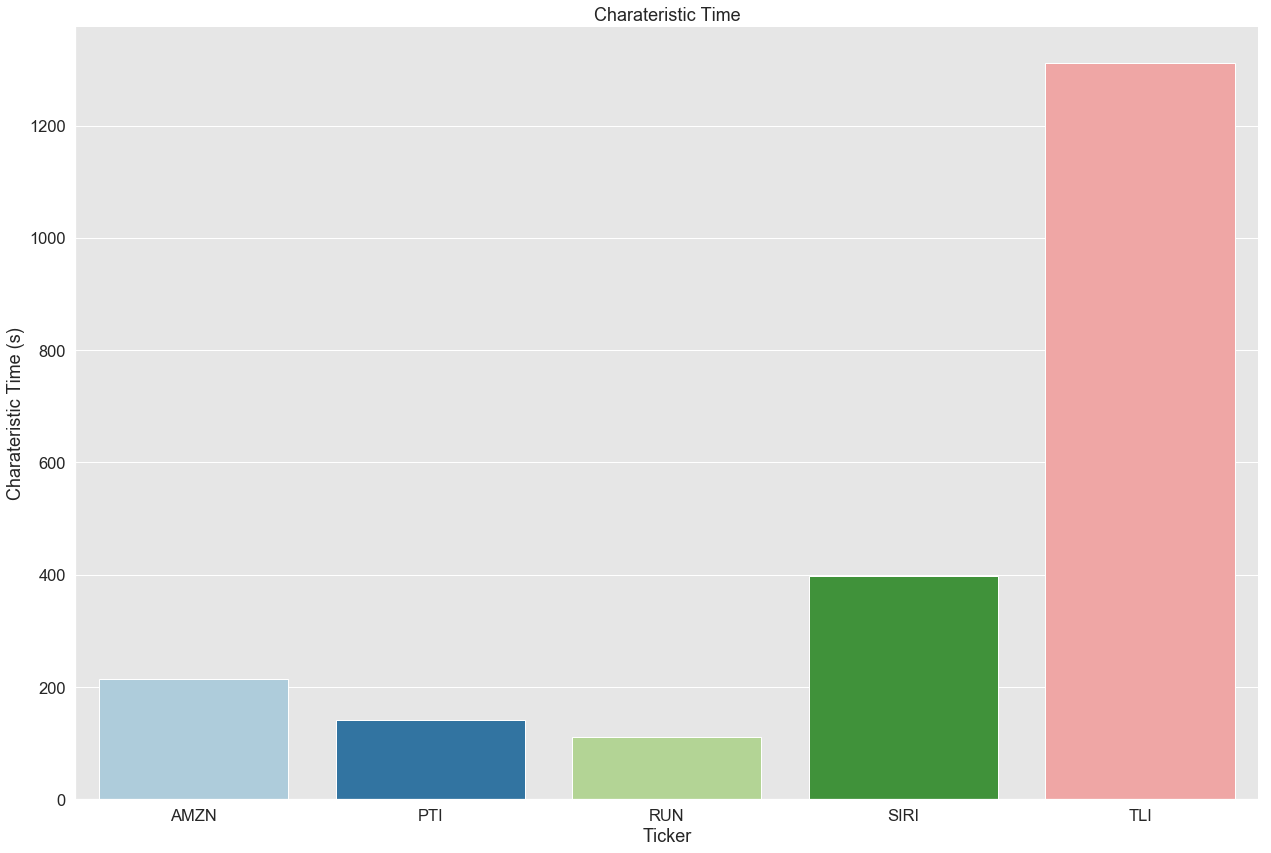

In [433]:
t_char = char_time.groupby('Ticker').mean().reset_index()
fig, ax = plt.subplots(figsize = (18,12))
_ = sns.barplot(y='char_time',x='Ticker', data=t_char,ax=ax)
_ = plt.ylabel('Charateristic Time (s)')
sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_trade_data_models/figures/char_time.png', format='png', dpi=300)
_ = plt.title('Charateristic Time')
plt.show()

In [429]:
mid_min = (nbbo_m.reset_index()
 .groupby(['Ticker',pd.Grouper(key='Timestamp',freq='D'),pd.Grouper(key='Timestamp',freq='5MIN')])[['Mid_price']]
 .apply(lambda x: x.max() - x.min())
)


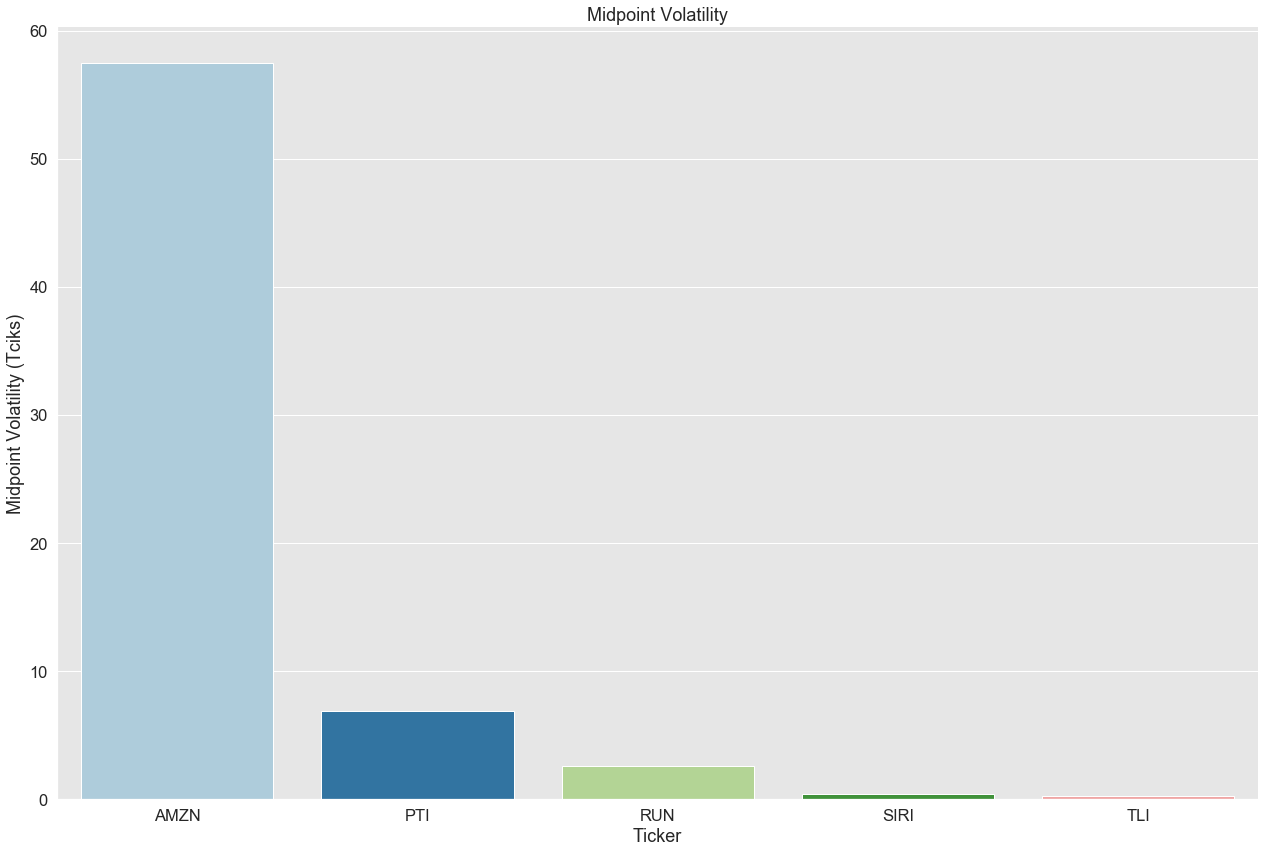

In [441]:
mid_vol = mid_min.groupby('Ticker').mean()*100
fig, ax = plt.subplots(figsize = (18,12))
_ = sns.barplot(y='Mid_price',x='Ticker', data=mid_vol.reset_index(),ax=ax)
_ = plt.ylabel('Midpoint Volatility (Tciks)')
sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_trade_data_models/figures/mid_vol.png', format='png', dpi=300)
_ = plt.title('Midpoint Volatility')
plt.show()

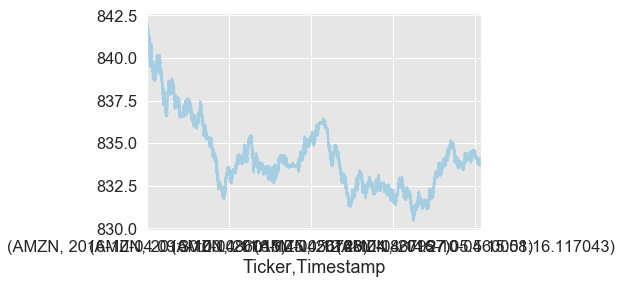

In [432]:
nbbo.loc[pd.IndexSlice['AMZN','2016-10-04'],:]['Mid_price'].plot()

In [423]:
bac.loc[bac.Bid_price>20,:]

Bid_ex  Bid_price Ask_ex  Ask_price  \
Ticker Timestamp                                                        
BAC    2016-10-04 09:30:00.020851      T      25.40      T      27.23   
       2016-10-04 09:30:01.072475      K    1181.95      P    1272.59   
       2016-10-04 09:30:01.078464      K    1181.95      T    1361.68   
       2016-10-04 09:30:02.084023      P    1181.96      T    1361.68   
       2016-10-04 09:30:02.184661      P    1181.96      T    1361.68   
       2016-10-04 09:30:09.123266      T      26.22      N      26.30   
       2016-10-04 09:30:10.427802      N      26.92      T      27.00   
       2016-10-04 09:31:06.398274      T      26.22      N      26.30   
       2016-10-04 09:31:40.122961      N      26.22      N      26.30   
       2016-10-04 09:32:22.911117      N      26.37      K      26.40   
       2016-10-04 09:33:42.500107      N      26.92      N      27.03   
       2016-10-04 09:33:42.502153      N      26.92      T      27.00   
       2016-10-04 09:33:44.639677      N      26.92      Y      27.00   
       2016-10-04 09:33:44.639944      N      26.93      Y      27.00   
       2016-10-04 09:33:44.640529      N      26.93      N      27.03   
       2016-10-04 09:33:54.031358      N      26.35      Y      26.39   
       2016-10-04 09:34:37.074570      N      26.92      Y      26.99   
       2016-10-04 09:35:25.772711      N      26.92      Y      26.98   
       2016-10-04 09:35:25.776343      N      26.93      Y      26.98   
       2016-10-04 09:35:25.776888      N      26.93      N      27.00   
       2016-10-04 09:35:26.067951      N      26.92      Y      26.99   
       2016-10-04 09:35:31.015189      N      26.92      N      27.00   
       2016-10-04 09:35:31.015291      N      26.92      Y      26.98   
       2016-10-04 09:36:20.491389      N      26.92      N      27.00   
       2016-10-04 09:36:20.491598      Y      26.93      N      27.00   
       2016-10-04 09:37:05.165285      N      26.92      N      27.00   
       2016-10-04 09:37:05.165395      Y      26.93      N      27.00   
       2016-10-04 09:37:05.165420      N      26.92      N      27.00   
       2016-10-04 09:37:31.168173      K      27.15      N      27.16   
       2016-10-04 09:38:01.757092      K      27.15      Y      27.16   
...                                  ...        ...    ...        ...   
       2016-10-04 15:58:35.534051      Y      26.91      N      26.98   
       2016-10-04 15:58:36.001522      N      27.02      T      27.07   
       2016-10-04 15:58:36.019347      N      27.02      T      27.07   
       2016-10-04 15:58:36.026882      N      27.03      T      27.07   
       2016-10-04 15:58:36.436500      P      26.30      N      26.33   
       2016-10-04 15:58:50.015501      P      26.30      N      26.33   
       2016-10-04 15:58:50.466394      P      26.30      N      26.33   
       2016-10-04 15:58:58.692213      Z      26.30      N      26.33   
       2016-10-04 15:59:16.568093      P      26.30      N      26.33   
       2016-10-04 15:59:16.898765      N      26.42      P      26.56   
       2016-10-04 15:59:19.441756      Z      26.30      N      26.33   
       2016-10-04 15:59:33.653292      N      26.91      Y      26.98   
       2016-10-04 15:59:45.006003      N      26.91      Y      26.98   
       2016-10-04 15:59:45.006423      Z      26.30      N      26.33   
       2016-10-04 15:59:48.014063      Z    1218.01      K    1220.00   
       2016-10-04 15:59:48.014893      Z    1218.01      K    1220.00   
       2016-10-04 15:59:48.015649      Z    1218.01      K    1220.00   
       2016-10-04 15:59:48.015873      Z    1218.01      K    1220.00   
       2016-10-04 15:59:48.017748      Z    1218.01      K    1220.00   
       2016-10-04 15:59:48.019231      Z    1218.01      K    1220.00   
       2016-10-04 15:59:48.020465      Z    1218.01      N    1220.50   
       2016-10-04 15:59:48.060876      Z    1218.01      N    1220.00   
       2016-10-04 1